In [75]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split , GridSearchCV

from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


In [174]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [175]:
df = pd.read_csv('price_data.csv')

In [176]:
df.head()

,brand,3G,4G,5G,Announced,Status,Weight,Length,Width,Diameter,SIM,Display Type,Display Size,ppi,body ratio,OS,battery_capacity,Price,CPU,ratio,pixel,GPU,Loudspeaker,3.5mm jack,Chipset,Card slot,RAM,Storage
0,0,True,True,False,2022.0,0,172.0,146.7,71.9,10.0,2,1,5.50,293.0,74.0,0,3000.0,100.0,4.0,3,1036800.0,5,True,True,4,7,2.0,32.0
1,0,True,True,False,2021.0,0,190.0,156.4,74.8,9.7,2,1,6.10,282.0,78.1,0,3000.0,110.0,8.0,11,1123200.0,4,True,True,8,7,2.0,32.0
2,0,True,True,False,2021.0,0,134.0,137.6,65.7,9.8,2,1,5.00,215.0,71.4,0,2000.0,60.0,4.0,3,460800.0,5,True,True,4,6,1.0,8.0
3,0,True,True,False,2021.0,0,194.0,165.6,75.6,8.7,2,1,6.52,269.0,82.0,0,4000.0,330.0,8.0,5,1152000.0,5,True,True,4,7,4.0,64.0
4,0,True,True,False,2021.0,0,190.0,165.6,75.6,8.8,2,1,6.52,269.0,82.0,0,4000.0,130.0,8.0,5,1152000.0,5,True,True,4,7,3.0,32.0


In [177]:
X = df.drop('Price', axis=1)
Y=df['Price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)


X_tr, X_val, y_tr, y_val= train_test_split(X_train, Y_train, test_size=0.15, random_state=42)

In [178]:
df.columns

Index(['brand', '3G', '4G', '5G', 'Announced', 'Status', 'Weight', 'Length',
       'Width', 'Diameter', 'SIM', 'Display Type', 'Display Size', 'ppi',
       'body ratio', 'OS', 'battery_capacity', 'Price', 'CPU', 'ratio',
       'pixel', 'GPU', 'Loudspeaker', '3.5mm jack', 'Chipset', 'Card slot',
       'RAM', 'Storage'],
      dtype='object')

In [179]:
selected_features = ['brand', '3G','Announced','Length', 'Diameter', 'Loudspeaker','Chipset','GPU', 'RAM','Display Size', 'Storage','SIM' , 'Display Type' , 'Status' ]


X_tr_selected = X_tr[selected_features]

X_val_selected = X_val[selected_features]

X_test_selected = X_test[selected_features]

In [194]:
scaler = {
    "StandardScaler": StandardScaler()
}

models = {
    "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "AdaBoostRegressor": AdaBoostRegressor() , 
    "XGBRegressor": xgb.XGBRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor()
    }

params = {
    "DecisionTreeRegressor": {
        "max_depth": [3, 5, 7],
        "min_samples_split": [2, 5, 10]
    },
    "XGBRegressor": {
        "learning_rate": [0.05, 0.1, 0.15],
        "max_depth": [3, 5, 7],
        "min_child_weight": [1, 3, 5],
        "subsample": [0.7, 0.8, 0.9],
        "colsample_bytree": [0.7, 0.8, 0.9],
        "n_estimators": [100, 200, 300]
    },
    "AdaBoostRegressor": {
        "n_estimators": [50, 100, 200 , 400],
        "learning_rate": [0.01, 0.05, 0.1, 0.5]
    },
    "LinearRegression": {},
    "GradientBoostingRegressor": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7 , 8 , 9 , 10]
    }
}
train_r2_scores = []
val_r2_scores = []
train_mse_scores = []
val_mse_scores = []


best_model = None
best_scaler = None
best_score_train = float('-inf')
best_score_val = float('-inf')
best_params = {}

for scaler_name, scaler in scaler.items():
    X_tr_scaled = scaler.fit_transform(X_tr_selected)
    X_val_scaled = scaler.transform(X_val_selected)
    
    for model_name, model in models.items():
        print(f"{model_name}   with   {scaler_name} ")
        
        grid_search = GridSearchCV(model, params[model_name], scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
        
        grid_search.fit(X_tr_scaled, y_tr)
        y_pred_tr = grid_search.predict(X_tr_scaled)
        y_pred_val = grid_search.predict(X_val_scaled)
        
        mse_train = mean_squared_error(y_tr, y_pred_tr)
        mse_val = mean_squared_error(y_val, y_pred_val)
        
        r2_train = r2_score(y_tr, y_pred_tr)  
        r2_val = r2_score(y_val, y_pred_val)  
        
        print(f"Train MSE   {model_name} with {scaler_name}:    {mse_train}")
        print(f"Train R2 score  {model_name} with {scaler_name}:    {r2_train}")
        
        print(f"Validation MSE   {model_name} with {scaler_name}:    {mse_val}")
        print(f"Validation R2 score  {model_name} with {scaler_name}:    {r2_val}")  
        
        print(f"Best params : {grid_search.best_params_}")
        print('------------------------------------------------------------------------------------')
        

        train_r2_scores.append(r2_train)
        val_r2_scores.append(r2_val)
        train_mse_scores.append(mse_train)
        val_mse_scores.append(mse_val)

        
              
        if r2_val > best_score_val:
            best_score_train = r2_train
            best_score_val = r2_val
            best_model = model_name
            best_scaler = scaler_name
            best_params = grid_search.best_params_

print(f"\nBest model: {best_model} with {best_scaler} ")
print(f"Best Train R2 score: {best_score_train}")
print(f"Best Validation R2 score: {best_score_val}")
print(f"Best params: {best_params}")

LinearRegression   with   StandardScaler 
Train MSE   LinearRegression with StandardScaler:    12329.545111800806
Train R2 score  LinearRegression with StandardScaler:    0.5690141839052126
Validation MSE   LinearRegression with StandardScaler:    9011.292226320333
Validation R2 score  LinearRegression with StandardScaler:    0.6262902794661667
Best params : {}
------------------------------------------------------------------------------------
DecisionTreeRegressor   with   StandardScaler 
Train MSE   DecisionTreeRegressor with StandardScaler:    6976.17850904606
Train R2 score  DecisionTreeRegressor with StandardScaler:    0.7561439647058483
Validation MSE   DecisionTreeRegressor with StandardScaler:    7708.065549152998
Validation R2 score  DecisionTreeRegressor with StandardScaler:    0.680336743068126
Best params : {'max_depth': 7, 'min_samples_split': 5}
------------------------------------------------------------------------------------
AdaBoostRegressor   with   StandardScaler 

# model validation with test data

In [216]:
best_model = GradientBoostingRegressor (learning_rate =0.05, max_depth =3, n_estimators =300)
best_scaler = StandardScaler()

X_train_scaled = best_scaler.fit_transform(X_tr_selected)
X_test_scaled = best_scaler.transform(X_test_selected)

best_model.fit(X_train_scaled, y_tr)

y_test_pred = best_model.predict(X_test_scaled)

test_r2 = r2_score(Y_test, y_test_pred)
test_mse = mean_squared_error(Y_test, y_test_pred)

print(f"R2 Score on test set: {test_r2}")
print(f"MSE on test set: {test_mse}")

R2 Score on test set: 0.7914219500715205
MSE on test set: 6307.529155506736


## plots for R2score and MSE comparison

In [217]:
models_names = list(models.keys())

### R2 score

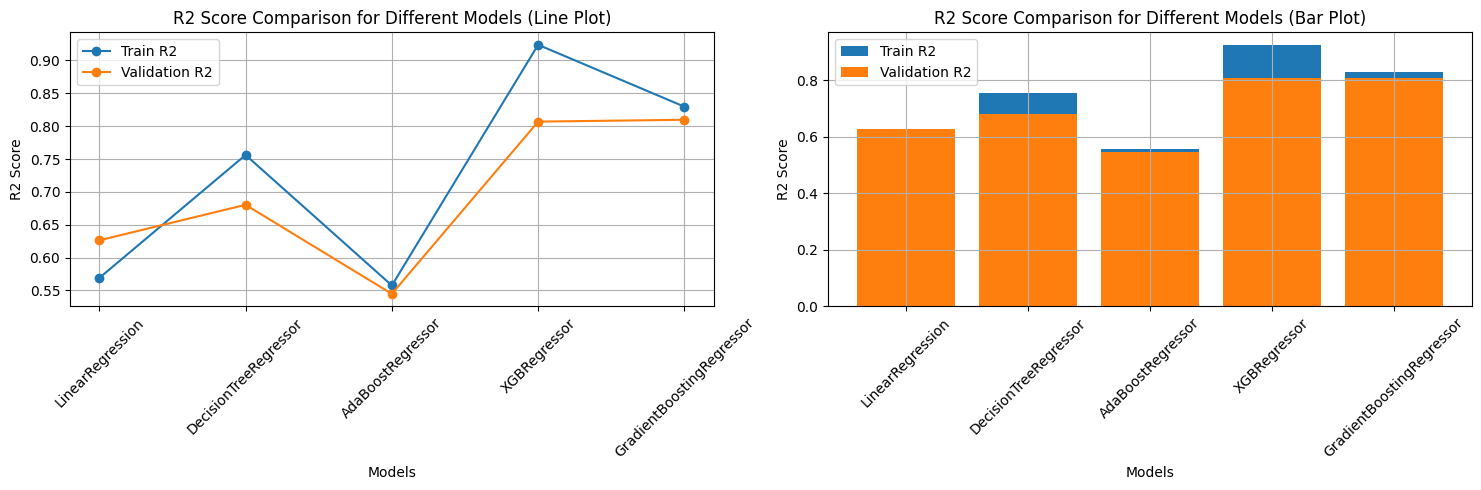

In [219]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(models_names, train_r2_scores, marker='o', label='Train R2')
plt.plot(models_names, val_r2_scores, marker='o', label='Validation R2')
plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.title('R2 Score Comparison for Different Models (Line Plot)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)


plt.subplot(1, 2, 2)
plt.bar(models_names, train_r2_scores, label='Train R2')
plt.bar(models_names, val_r2_scores, label='Validation R2')
plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.title('R2 Score Comparison for Different Models (Bar Plot)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()


### MSE

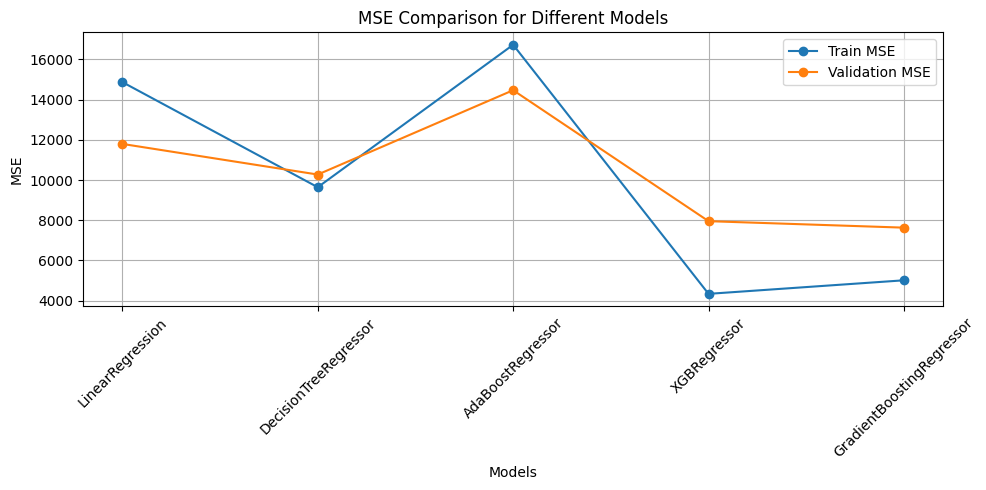

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(models.keys(), train_mse_scores, marker='o', label='Train MSE')
plt.plot(models.keys(), val_mse_scores, marker='o', label='Validation MSE')
plt.xlabel('Models')
plt.ylabel('MSE')
plt.title('MSE Comparison for Different Models')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### AcTUAL VS PREDICTED PRICES

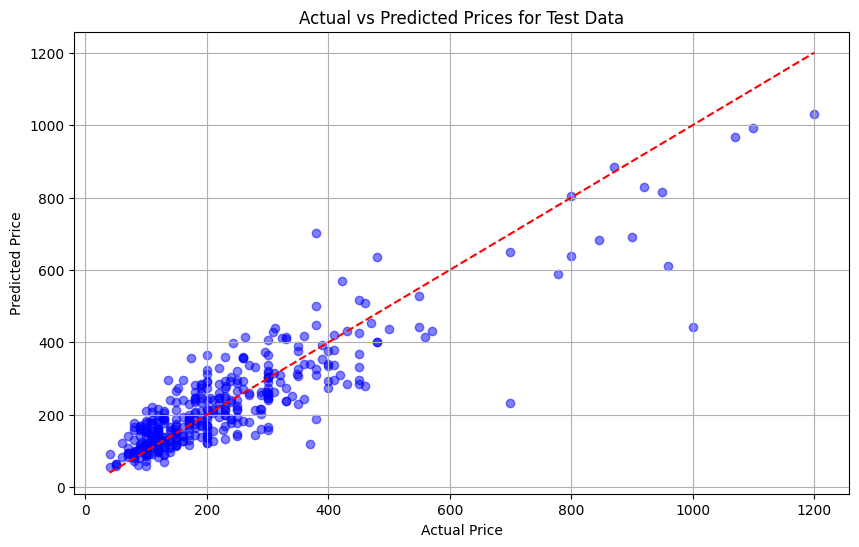

In [211]:
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, y_test_pred, color='blue', alpha=0.5)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices for Test Data')
plt.grid(True)
plt.show()

## feature importance

In [220]:
feature_importance = best_model.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": selected_features, "Importance": feature_importance})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

print(feature_importance_df)

         Feature  Importance
8            RAM    0.402227
9   Display Size    0.079812
2      Announced    0.075350
4       Diameter    0.072118
3         Length    0.070269
10       Storage    0.065901
5    Loudspeaker    0.065443
0          brand    0.047455
12  Display Type    0.031322
7            GPU    0.029101
11           SIM    0.028973
6        Chipset    0.026939
13        Status    0.004985
1             3G    0.000105


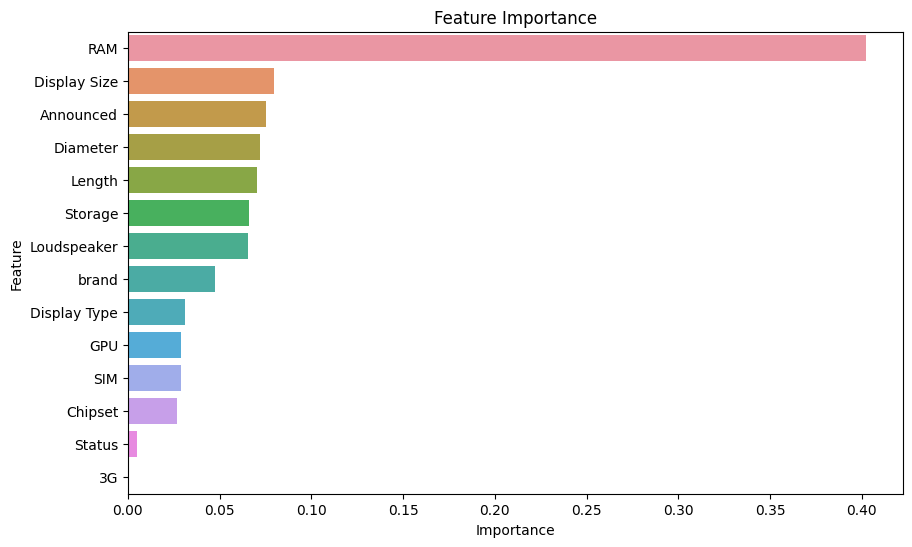

In [221]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Feature importance analysis

#### RAM (Random Access Memory):
Importance: 0.384907
    
RAM is one of the most significant factors affecting the price of mobile devices. Devices with higher RAM capacity are capable of running more complex applications and games with fewer lags, providing a better user experience. Additionally, battery consumption and faster performance are considerably dependent on RAM. Therefore, the price is highly correlated with the RAM of the device.



#### Storage:
Importance: 0.120119

The impact of internal storage on the price of devices is quite clear and expected. Phones with higher internal storage capacity offer more storage options for consumers.



#### Display Size:
Importance: 0.088772

Devices with larger displays usually have higher prices as they require better and newer technologies for superior quality and consume more resources for manufacturing. Moreover, using devices with larger displays is much more comfortable than smaller ones.



#### Announced:
Importance: 0.072435

The release date of a device can significantly influence its price. Generally, devices released with more advanced technologies and capabilities than previous models and offering higher quality may have higher prices.



#### Brand:
Importance: 0.062845

Well-known brands typically set higher prices for their products as they are recognized as symbols of quality and trust in the market. Consumers expect better quality and user experience from these brands, and they also incorporate the latest technologies. Therefore, it is logical that they have different prices compared to other brands.



#### Diameter:
Importance: 0.054311

The diameter of a phone can also be considered as a physical feature affecting its price. An increase in diameter usually means a larger display and a better user experience, which may lead to a higher price.



#### Loudspeaker:
Importance: 0.041868

The quality of loudspeakers can be important for consumers. Devices with high-quality loudspeakers tend to have higher prices.



#### Display Type (OLED):
Importance: 0.024971

The type of display significantly affects the user experience. For example, OLED displays are generally known for superior quality and color compared to LCD and TFT, which may lead to higher prices for devices with this type of display. Additionally, Retina displays are exclusive to the Apple brand and offer their unique quality and colors, which logically have a good impact on the prices of the devices.